# 4 - Preprocessing and Modeling

In [90]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, balanced_accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import set_config
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 


In [91]:
# Lemmatizer class taken from stack overflow used in EDA and preprocessing

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [92]:
qpr = pd.read_csv('../datasets/qpr.csv')
liv = pd.read_csv('../datasets/liv-2.csv')

/var/folders/5h/p8nqld_13hg44lctlhg2ns8c0000gn/T/ipykernel_6176/2028626020.py:2: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  liv = pd.read_csv('../datasets/liv-2.csv')


In [93]:
liv.dtypes

subreddit      object
body           object
length         object
date_posted    object
dtype: object

In [94]:
# liv df has processed badly and needs fixing

liv.shape

(1190802, 4)

In [95]:
liv.dropna(inplace=True)

In [96]:
liv.length = liv.length.astype(int)

In [97]:
liv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139673 entries, 0 to 1190801
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   subreddit    139673 non-null  object
 1   body         139673 non-null  object
 2   length       139673 non-null  int64 
 3   date_posted  139673 non-null  object
dtypes: int64(1), object(3)
memory usage: 5.3+ MB


In [98]:
qpr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7917 entries, 0 to 7916
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    7917 non-null   object
 1   body         7917 non-null   object
 2   length       7917 non-null   int64 
 3   date_posted  7917 non-null   object
dtypes: int64(1), object(3)
memory usage: 247.5+ KB


In [99]:
df = pd.concat((qpr, liv), axis = 0)

In [100]:
df.head()

,subreddit,body,length,date_posted
0,superhoops,Calls him disgrace but still says good play...,24,2011-09-26
1,superhoops,BBC Football Tactics Goalshy QPR need forma...,11,2011-09-26
2,superhoops,Sept you are hurting inside you can really ...,37,2011-09-26
3,superhoops,This great resource which been using since ...,34,2011-09-26
4,superhoops,Warnock unhappy with refereeing decisions gam...,12,2011-09-26


In [101]:
# Binarizing the target variable 'subreddit'

df['team'] = df.subreddit.replace({
    'LiverpoolFC' : 1,
    'superhoops' : 0
})

# Regex pattern to clean dataframes, similar to in 3-EDA

df['body'] = df['body'].str.replace('\d+', '') # for digits
df['body'] = df['body'].str.replace(r'(\b\w{1,2}\b)', '') # for words
df['body'] = df['body'].str.replace('[^\w\s]', '') # for punctuation 

liv.body.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)

# '_' found in output tokenized df, converted to empty string

liv.body = liv.body.str.replace('_', '')

/var/folders/5h/p8nqld_13hg44lctlhg2ns8c0000gn/T/ipykernel_6176/1616342138.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['body'] = df['body'].str.replace('\d+', '') # for digits
/var/folders/5h/p8nqld_13hg44lctlhg2ns8c0000gn/T/ipykernel_6176/1616342138.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['body'] = df['body'].str.replace(r'(\b\w{1,2}\b)', '') # for words
/var/folders/5h/p8nqld_13hg44lctlhg2ns8c0000gn/T/ipykernel_6176/1616342138.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['body'] = df['body'].str.replace('[^\w\s]', '') # for punctuation


In [102]:
# smaller dataframe of reverse alphabetically sorted body columns
# used to show some success of models even on a small slice of data 

df_n = df.sort_values(by = 'body', ascending = False).head(10000)

In [103]:
# Assigning X and y for train test split

X = df_n['body']
y = df_n['team']



In [104]:
#check for X length
X.shape

(10000,)

In [105]:
# original distribution of target variable, and also the null model

y.value_counts(normalize = True)

1    0.9394
0    0.0606
Name: team, dtype: float64

## Baseline Null Model
---
- Null model predicts a positive class with accuracy of 93.9%, since the dataset is so imbalanced, balanced accuracy will be the unit of measurement used to determine model strength.
- Null model balanced accuracy is 50%

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=222, stratify =y)

In [107]:
set_config(transform_output='pandas')

In [108]:
X_test

71022       Where  buy  home kit Liverpool store out  stock
3368      When Nedum got beat  Sissoko for the game winn...
29286     Winning the league brought the funniest Scouse...
76403     What  the obsession  the  with XmasNew Year fo...
55793     Wonder  the Missus will notice the slight adju...
                                ...                        
4962      Why Darwin Nunez rejected bigger offer from Ma...
75003     When Clyne  back  the mix does  make sense  pu...
75275     Yesterday Naby Keita has registered company in...
794321    What happened  the rumours surrounding him wan...
831546    httpimgurcomJWscW\n\nand\n\nTony Barrett says ...
Name: body, Length: 2500, dtype: object

In [109]:
# Lemmatizer used as tokenizer, count vectorization produced a matrix of all
# not in 'stop_words = 'english''
# 'min_df = 10' prevents tokenizing of words that occur less than 10 times.
# train data transformed and fitted, test data only transformed

cvx = CountVectorizer(tokenizer=LemmaTokenizer(),
                      stop_words='english', min_df=10)

X_train_cv = cvx.fit_transform(X_train)
X_train_cv = pd.DataFrame(X_train_cv.todense(), columns=cvx.get_feature_names_out())

X_test_cv = cvx.transform(X_test)
X_test_cv = pd.DataFrame(X_test_cv.todense(), columns=cvx.get_feature_names_out())

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [110]:
# column inspection

X_train_cv.head()

,ability,able,absence,absentee,absolute,absolutely,academy,accept,according,account,...,ynwa,ynwsa,young,younger,youngster,youth,youtube,zero,zidane,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
X_train_cv.shape

(7500, 2065)

In [112]:
y_train.value_counts(normalize = True)

1    0.939467
0    0.060533
Name: team, dtype: float64

In [113]:
# lr = LogisticRegression()

# lr.fit(X_train_cv, y_train)

In [114]:
# Basic Logistic Regression model fitted and tested

logr = LogisticRegression()

logr.fit(X_train_cv, y_train)



LogisticRegression()

In [115]:
print(logr.score(X_train_cv, y_train))
print(logr.score(X_test_cv, y_test))

0.9742666666666666
0.9596


- Train and test accuracies are comparable to the base line model, but do not indicate any strenth of the model

- see later tests for balanced accuracy results from this model

In [116]:
# Pipeline of Random oversample and Logistic regression

pipe = Pipeline([
    ('ros', RandomOverSampler(random_state=222)),
    ('logr', LogisticRegression(max_iter=10_000))
])

In [117]:
# Gridsearch over this pipeline, previously obtained ideal parameters entered here
# to reduce run time issues
# scoring metric adjusted to balanced accuracy

gs_bal = GridSearchCV(
    pipe,
    param_grid={'ros__sampling_strategy' : [0.9]},
    cv = 3,
    verbose = 1,
    scoring = 'balanced_accuracy'
)

In [118]:
# best estimator and params displayed below (again, pre entered following investigation to
# combal cpu issues)

gs_bal.fit(X_train_cv, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ros',
                                        RandomOverSampler(random_state=222)),
                                       ('logr',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'ros__sampling_strategy': [0.9]},
             scoring='balanced_accuracy', verbose=1)

In [119]:
gs_bal.best_params_

{'ros__sampling_strategy': 0.9}

In [120]:
gs_bal.best_estimator_.fit(X_train_cv, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=222, sampling_strategy=0.9)),
                ('logr', LogisticRegression(max_iter=10000))])

In [121]:
gs_bal.score(X_train_cv, y_train)

0.9809367892052353

In [122]:
gs_bal.score(X_test_cv, y_test)

0.7504314982515915

### Random Oversample/Logistic Regression
---
- Balanced accuracy of 75% is better than that of the null model, however still badly predicts the subreddit of the post

In [123]:
# pa = Pipeline([
#     ('ada', ADASYN(random_state=42, n_jobs = -1)),
#     ('logr', LogisticRegression(max_iter=10_000))
# ])

# gs_a = GridSearchCV(
#     pa,
#     param_grid={
#         'ada__sampling_strategy': [0.1,0.3,0.9],
#         'ada__n_neighbors' : [3, 5, 10],
#         'logr__C': [0.1, 1, 10]
#     }, scoring = 'balanced_accuracy', n_jobs = -1, cv = 2, verbose = 1
# )

# %timeit

# gs_a.fit(X_train_cv, y_train)

# gs_a.best_estimator_

# gs_a.best_estimator_.fit(X_train_cv, y_train)

# gs_a.score(X_train_cv, y_train)

# gs_a.score(X_test_cv, y_test)

#### Adasyn
---
- Adasyn resampling tested, however produced even worse results and took a far longer time to run than ROS (random oversample), left for proof of attempt, however left out of future models

In [124]:
# Thank you Devin Fay, function adapted for personal need

def get_accuracies(X_train, y_train, X_test, y_test, model, model_name:str, scores_df=None, norm=None):
    
    # Takes training and test splits, a desired model and model name (string),
    # current scoring dataframe and norm parameter for the heatmap output
    
    # Creates columns for scoring metrics on first run
    if scores_df is None:
        scores_df = pd.DataFrame(columns = ['train_acc', 'test_acc', 'bal_acc'])
    
    # fits model to training data
    model.fit(X_train, y_train)
    
    # produces a confusion matrix for the prediction and true values of the test data
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', normalize=norm)
    
    # predicted subreddits for each row, used to calculate balanced accuracy
    preds = model.predict(X_test)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    bal_acc = balanced_accuracy_score(y_test, preds)

    # dataframe updated with model name and corresponding scores
    scores_df.loc[model_name,:] = [train_acc, test_acc, bal_acc]
    
    print(scores_df)
    
    return scores_df

             train_acc test_acc   bal_acc
bal_ros_logr  0.977733   0.9184  0.750431


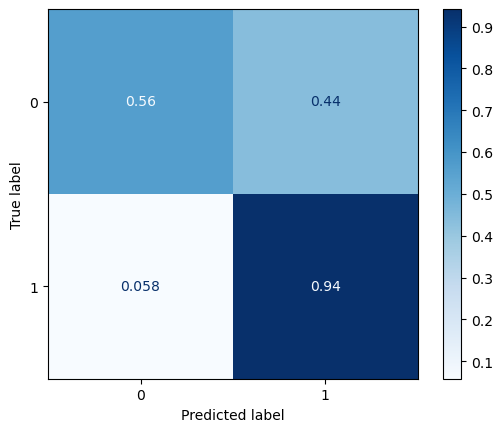

In [125]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_bal.best_estimator_, 'bal_ros_logr', scores_df = None, norm = 'true')

Key:
---
---

|Abbreviation|Meaning|
|-|-|
|bal|balanced|
|logr|LogisticRegression|
|ros|RandomOversampler|
|mnb|MultinomialNB|
|rf|RandomForest|
|bnb|BernoulliNB|
|stack|Stacked Model|
|et|ExtraTreesClassifier|

### RandomOversample - Logisitic Regression
---

- 0.56 True Negative score is very weak and this model only correctly predicts the minority class 56% of the time.

             train_acc test_acc   bal_acc
bal_ros_logr  0.977733   0.9184  0.750431
logr          0.974267   0.9596  0.713911


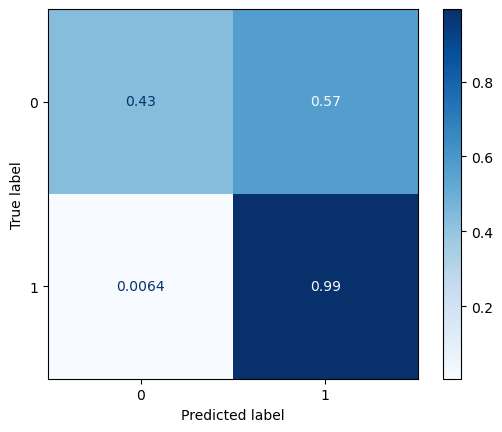

In [126]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, logr, 'logr', scores_df, norm = 'true')

### Logistic Regression
---

- True negative score (0.43) is lower than logr combined with ros, and when gridsearched with the scoring metric set to balanced accuracy (0.56).

In [127]:
# Pipeline with ros and mnb

pipe_mnb = Pipeline([
    ('ros', RandomOverSampler()),
    ('mnb', MultinomialNB())
])

In [128]:
# mnb was comparitively much less challenging computationally, so many parameters were tested

gs_mnb = GridSearchCV(
    pipe_mnb,
    param_grid={
        'ros__sampling_strategy' : [0.2, 0.35, 0.5,0.9, 1],
        'mnb__alpha' : [1, 2, 3, 5, 7, 8]
    }, cv = 5, verbose = 1, n_jobs=-1, scoring='balanced_accuracy'
)

In [129]:
gs_mnb.fit(X_train_cv, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ros', RandomOverSampler()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'mnb__alpha': [1, 2, 3, 5, 7, 8],
                         'ros__sampling_strategy': [0.2, 0.35, 0.5, 0.9, 1]},
             scoring='balanced_accuracy', verbose=1)

In [130]:
gs_mnb.best_estimator_

Pipeline(steps=[('ros', RandomOverSampler(sampling_strategy=1)),
                ('mnb', MultinomialNB(alpha=8))])

In [131]:
gs_mnb.best_params_

{'mnb__alpha': 8, 'ros__sampling_strategy': 1}

             train_acc test_acc   bal_acc
bal_ros_logr  0.977733   0.9184  0.750431
logr          0.974267   0.9596  0.713911
bal_ros_mnb     0.8716   0.8488  0.824134


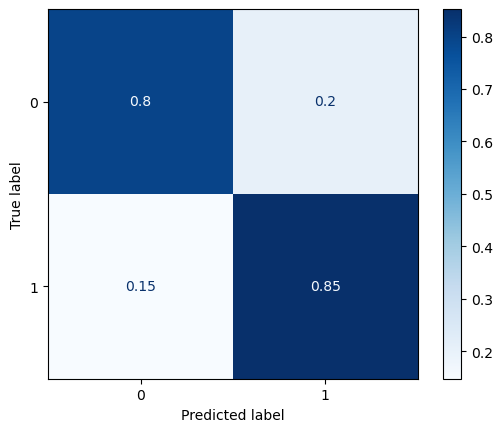

In [132]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_mnb.best_estimator_, 'bal_ros_mnb', scores_df, norm = 'true')

### RandomOversample - Multinomial Naive Bayes
---
- Very comparable True negative (0.81) and True Positive (0.85), even with such a small dataset. This model is by far the strongest, despite apparently lower train and test accuracy scores than logr models.
- This model uses the frequency of a words presence to determine the likely origin of that post. Since some words in this case are very subreddit specific (ie. 'qpr', 'liverpool') as well as specific player names from that team, this model is very effective as a predictor.

In [133]:
# Random Forest pipeline

pipe_rf = Pipeline([
    ('ros', RandomOverSampler()),
    ('rf', RandomForestClassifier())
])

In [134]:
gs_rf = GridSearchCV(
    pipe_rf,
    param_grid = {
        'ros__sampling_strategy' :[0.5],
        'rf__max_depth' : [3,5,7],
        'rf__n_estimators' : [80, 100, 120]
    }, cv = 2, verbose = 1, n_jobs=-1, scoring='balanced_accuracy'
)

In [135]:
gs_rf.fit(X_train_cv, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('ros', RandomOverSampler()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [3, 5, 7],
                         'rf__n_estimators': [80, 100, 120],
                         'ros__sampling_strategy': [0.5]},
             scoring='balanced_accuracy', verbose=1)

             train_acc test_acc   bal_acc
bal_ros_logr  0.977733   0.9184  0.750431
logr          0.974267   0.9596  0.713911
bal_ros_mnb     0.8716   0.8488  0.824134
bal_ros_rf    0.949867    0.948  0.572368


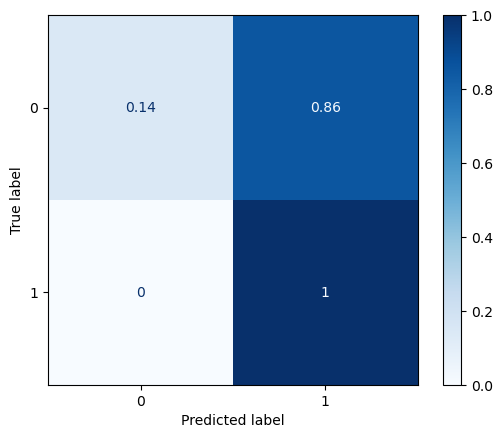

In [136]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_rf.best_estimator_, 'bal_ros_rf', scores_df, norm='true')

### RandomOversample - Random Forest Classifier
---

- Very low bias, hugely overfit model, 100% accuracy of the majority class, barely outperforms the null model in terms of balanced accuracy.

In [137]:
# Bernoulli pipeline with ros

pipe_bnb = Pipeline([
    ('ros', RandomOverSampler()),
    ('bnb', BernoulliNB())
])

In [138]:
gs_bnb = GridSearchCV(
    pipe_bnb,
    param_grid={
        'ros__sampling_strategy' : [0.2, 0.35, 0.5,0.9],
        'bnb__alpha' : [0.1, 0.4, 0.6, 0.9, 1]
    }, cv = 5, verbose = 1, n_jobs=-1, scoring='balanced_accuracy'
)

In [139]:
gs_bnb.fit(X_train_cv, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ros', RandomOverSampler()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'bnb__alpha': [0.1, 0.4, 0.6, 0.9, 1],
                         'ros__sampling_strategy': [0.2, 0.35, 0.5, 0.9]},
             scoring='balanced_accuracy', verbose=1)

In [140]:
gs_bnb.best_estimator_

Pipeline(steps=[('ros', RandomOverSampler(sampling_strategy=0.5)),
                ('bnb', BernoulliNB(alpha=1))])

             train_acc test_acc   bal_acc
bal_ros_logr  0.977733   0.9184  0.750431
logr          0.974267   0.9596  0.713911
bal_ros_mnb     0.8716   0.8488  0.824134
bal_ros_rf    0.949867    0.948  0.572368
bal_ros_bnb   0.934667   0.9112  0.771211


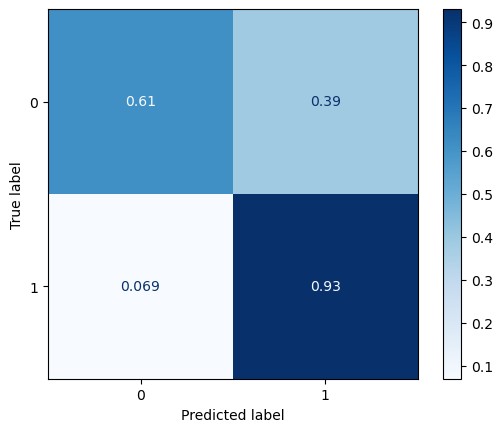

In [141]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_bnb.best_estimator_, 'bal_ros_bnb', scores_df, norm= 'true')

### RandomOversampler - Bernoulli Naive Bayes
---

- Stronger than Logistic regression models, but performed significantly worse than mnb model, since the subreddits are so closely related, we are likely to see most of the words appearing somewhere in the history of the subreddit. BNB only takes into account binary presence, meaning the frequency of a word is not relevant to the prediction. 
- For example, it is likely that in the qpr subreddit, liverpool were mentioned at least once, meaning this very clear predictor of subreddit has equal weighting for each subreddit.

In [152]:
# Stacking pipeline with mnb, bnb, and lr models

stack = [
    ('mnb' , gs_mnb.best_estimator_),
    ('bnb' , gs_bnb.best_estimator_),
    ('lr' , LogisticRegression(max_iter = 100_000)),
#     ('et', gs_et.best_estimator_)
    
]

In [153]:
# final estimator is the ros logr model used in the inital model
# initial expectations were for mnb to be the best final estimator, however this combination 
# proved the strongest

stx_mod = StackingClassifier(
    estimators=stack,
    final_estimator=gs_bal.best_estimator_
)

In [154]:
stx_mod.fit(X_train_cv, y_train)

StackingClassifier(estimators=[('mnb',
                                Pipeline(steps=[('ros',
                                                 RandomOverSampler(sampling_strategy=1)),
                                                ('mnb',
                                                 MultinomialNB(alpha=8))])),
                               ('bnb',
                                Pipeline(steps=[('ros',
                                                 RandomOverSampler(sampling_strategy=0.5)),
                                                ('bnb',
                                                 BernoulliNB(alpha=1))])),
                               ('lr', LogisticRegression(max_iter=100000))],
                   final_estimator=Pipeline(steps=[('ros',
                                                    RandomOverSampler(random_state=222,
                                                                      sampling_strategy=0.9)),
                                                   ('logr',
                                                    LogisticRegression(max_iter=10000))]))

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


             train_acc test_acc   bal_acc
bal_ros_logr  0.977733   0.9184  0.750431
logr          0.974267   0.9596  0.713911
bal_ros_mnb     0.8716   0.8488  0.824134
bal_ros_rf    0.949867    0.948  0.572368
bal_ros_bnb   0.934667   0.9112  0.771211
stack           0.8812   0.8484   0.83315
bal_ros_et    0.954133   0.9512  0.617143


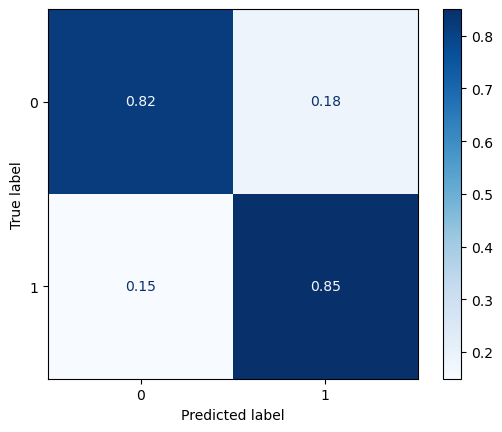

In [155]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, stx_mod, 'stack', scores_df, norm='true')

### Stacking
---

- Stacking bnb, logr and mnb models, with a balanced scored logr final estimator produced the best results in the large dataset scores, as well as this smaller slice of the data. 
- The True Positive and True Negative prediction accuracies are the closest out of all the models (0.86, 0.82) respectively, balanced accuracy is also the greatest (0.835), meaning this is the best model for accurately predicting the subreddit of origin for a post 
- This model easily outperforms the null model, which has a balanced accuracy of 50%

In [146]:
pipe_et = Pipeline([
    ('ros', RandomOverSampler()),
    ('et', ExtraTreesClassifier())
])

In [147]:
gs_et = GridSearchCV(
    pipe_et,
    param_grid={
        'ros__sampling_strategy' : [0.9],
        'et__min_samples_split' : [3],
        'et__max_depth' : [5]
    }, cv = 3, verbose= 1, n_jobs=-1, scoring='balanced_accuracy'
)

In [148]:
gs_et.fit(X_train_cv, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ros', RandomOverSampler()),
                                       ('et', ExtraTreesClassifier())]),
             n_jobs=-1,
             param_grid={'et__max_depth': [5], 'et__min_samples_split': [3],
                         'ros__sampling_strategy': [0.9]},
             scoring='balanced_accuracy', verbose=1)

In [149]:
gs_et.best_estimator_

Pipeline(steps=[('ros', RandomOverSampler(sampling_strategy=0.9)),
                ('et', ExtraTreesClassifier(max_depth=5, min_samples_split=3))])

             train_acc test_acc   bal_acc
bal_ros_logr  0.977733   0.9184  0.750431
logr          0.974267   0.9596  0.713911
bal_ros_mnb     0.8716   0.8488  0.824134
bal_ros_rf    0.949867    0.948  0.572368
bal_ros_bnb   0.934667   0.9112  0.771211
stack         0.879333   0.8548  0.827328
bal_ros_et    0.954133   0.9512  0.617143


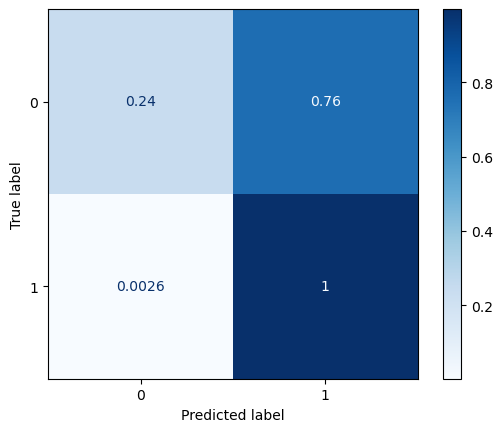

In [150]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_et.best_estimator_, 'bal_ros_et', scores_df, norm='true')

### RandomOversampler - ExtraTreesClassifier
---

- Whilst Extra Trees outperforms the null model and Random Forest, it still poorly predicts the minority class, balanced accuracy is far lower than mnb and stacked models.

In [151]:
scores_df

,train_acc,test_acc,bal_acc
bal_ros_logr,0.977733,0.9184,0.750431
logr,0.974267,0.9596,0.713911
bal_ros_mnb,0.8716,0.8488,0.824134
bal_ros_rf,0.949867,0.948,0.572368
bal_ros_bnb,0.934667,0.9112,0.771211
stack,0.879333,0.8548,0.827328
bal_ros_et,0.954133,0.9512,0.617143


# Model Scores from Before CPU Issues

|**Model Type**|Train Accuracy|Test Accuracy|Balanced Accuracy|
|---|---|---|--|
|bal_ros_logr|0.984797|0.969457|0.886196|
logr|0.990831|0.985329|0.810065|
bal_ros_mnb|0.943318|0.939618|0.913168|
bal_ros_rf|0.967101|0.966798|0.511117|
bal_ros_bnb|0.973364|0.968085|0.855257|
stack|0.952744|0.947889|0.92208|
bal_ros_et|0.967673|0.967004|0.517318|


### Initial Outcomes
---
Despite having little attention directed to cleaning of special characters, numbers, non english words and spam posts, these models generally performed well in terms of balanced accuracy. With greater computational power, I believe the bal_ros_mnb and stack models would have produced very strong balanced accuracy scores on fully cleaned data, and would have therefore been very effective in predicting the original subreddit for a body of text. 

These findings show that despite the similarity in these subreddits, the language used is distinct enough to successfully distinguish and hence correctly predict the original subreddit with very high accuracy.

# Conclusions

- The success of a football team generally has a positive impact on community activity and post frequency.
- Larger teams are likely to have a more toxic community in terms of swear words used per post than smaller teams. There are exceptions to this however, since some words are more commonly used in certain dialects. 
- In general, increased success of a team results in a lower post length on average.
- Language models are shown to be able to predict the original subreddit of a text body with high accuracy, despite initial predictions suggesting that the language used would be too similar to form clear distinctions.

# Recommendations

- Collecting data proved to be challenging, since Liverpools subreddit was so large, and QPRs was so small. Collecting comments from Liverpools subreddit would result in too large a data imbalance, but would be required to reliably compare language across all types of text body. Certain language is more likely in comments than in prose paragraphs or titles. Despite this, the choice to only use first level comments would have reduced this, since reactions to comments are likely contributing to differences in language used the most.

- Comparing language used with a focus on dialect differences would be an interesting follow up route, which was breifly introduced upon inspection of swear word frequency.
